In [765]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
def rigid_transform(image, scale_alpha, trans_x, trans_y, rot_beta):
    # Apply a rigid (geometric) transform: scale, translation, rotation via bilinear interpolation
    N,_,H,W = image.shape
    coords = torch.stack(torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W),indexing='xy') )
    cos_b = torch.cos(rot_beta/180 *torch.pi)
    sin_b = torch.sin(rot_beta/180 *torch.pi)
    coords_transf = torch.einsum("bcd,dl->bcl", (torch.stack([
    torch.stack([scale_alpha * cos_b, scale_alpha * sin_b, -trans_x/(W/2)], dim=-1),
    torch.stack([-scale_alpha * sin_b, scale_alpha * cos_b, -trans_y/(H/2)], dim=-1),
    torch.tensor([0., 0., 1.]).expand(N, -1)
], dim=1),torch.stack([*coords.flatten(-2),torch.ones(H*W)])))[:,:2].reshape(N,2, H, W).moveaxis(1,-1)
    return torch.nn.functional.grid_sample(
        image,
        coords_transf,
        mode='bilinear',
        align_corners=True,
    )
def highpass_kernel(shape):
    ans = torch.outer(torch.blackman_window(shape[0]), torch.blackman_window(shape[1]))
    return torch.abs(ans - torch.max(ans)).unsqueeze(0).unsqueeze(0)
def apply_highpass(img, high_pass_kernel):
    return img.abs() * high_pass_kernel
def phase_correlation(im, template):
    imFft = torch.fft.rfft2(im)
    templayteFft = torch.fft.rfft2(template)
    return torch.fft.ifftshift(torch.fft.irfft2((imFft*templayteFft.conj())/(imFft*templayteFft).abs()))

def fft2d(img):
    return torch.fft.fftshift(torch.fft.fft2(img))
def ifft2d(img):
    return torch.fft.ifft2(torch.fft.ifftshift(img))

image = torchvision.io.read_image('public/mandrill.png')/255.
N=20
bimage = image.unsqueeze(0).expand(N,-1,-1,-1)
gtScale = torch.rand(N)+0.75
gtAngle = torch.randint(-90, 90, (N,)).float()
trans_x = 1*(torch.rand(N)-1)*2
trans_y = 1*(torch.rand(N)-1)*2
bimageTransf = rigid_transform(bimage, gtScale, trans_x, trans_y, gtAngle)

In [782]:
import math


import math
class LogPolarRepresentation(torch.nn.Module):
    def __init__(self, H,W):
        super().__init__()
        self.H = H
        self.W = W
    def get_radius(self):
        return (torch.norm(torch.tensor([self.H,self.W], dtype=torch.float32))/2).long().item()
    def remap(self, img, grid):
        return torch.nn.functional.grid_sample(
            img, grid.clamp(-1,1).unsqueeze(0).expand(img.size(0),*3*[-1]), mode='bilinear', align_corners=True
        )
    def xy_grid(self):
        x,y = torch.meshgrid(*[torch.linspace(1,-1,self.H),torch.linspace(1,-1,self.W)], indexing="xy")
        return x,y
    def pol2cartgrid(self):
        radius = self.get_radius()
        indices = torch.complex(*self.xy_grid())
        return (radius*indices.abs()/math.sqrt(2)).log()/math.log(radius)*2-1, indices.angle()/torch.pi 
    def thetarho_grid(self):
        radius = (torch.norm(torch.tensor([self.H,self.W], dtype=torch.float32))/2).long().item()
        theta, r = torch.meshgrid(*[torch.arange(360),torch.arange(radius)])
        return theta, radius ** (r / radius)
    def cart2polgrid(self):
        theta, rho = self.thetarho_grid()
        indices = torch.polar(rho, theta * torch.pi / 180)
        return indices.real +self.W // 2, indices.imag + self.H // 2
    def cart2pol(self, img):
        x_indices, y_indices = self.cart2polgrid()
        grid = torch.stack([(x_indices / (img.shape[-2] - 1)) * 2 - 1, (y_indices / (img.shape[-1] - 1)) * 2 - 1], dim=-1)
        return self.remap(
            img, grid
        )
    def pol2cart(self, img):
        grid = torch.stack(self.pol2cartgrid(), dim=-1)
        return self.remap(
            img, grid
        )

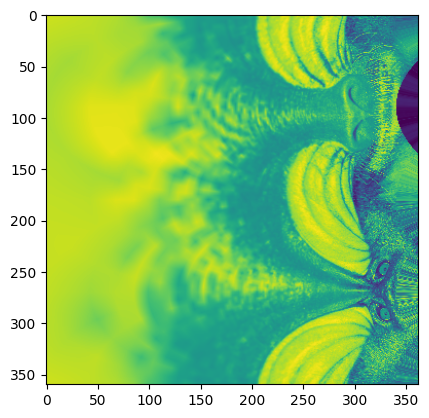

In [783]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimage
)[0].mean(0))

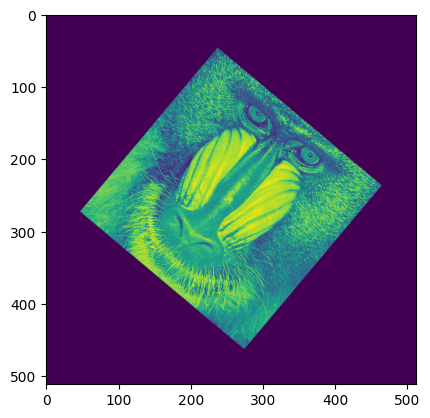

In [784]:
plt.imshow(
        bimageTransf
[6].mean(0))

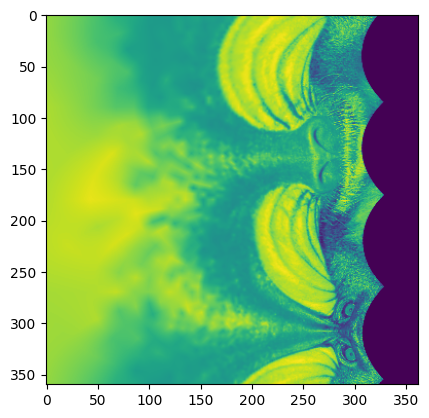

In [769]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimageTransf
)[6].mean(0))

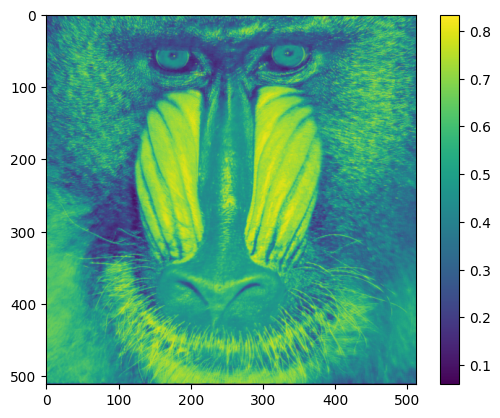

In [770]:
plt.imshow(LogPolarRepresentation(*bimage.shape[-2:]).pol2cart(LogPolarRepresentation(*bimage.shape[-2:]).cart2pol(
        bimage
))[6].mean(0))
plt.colorbar()
plt.imshow(bimage[6].mean(0), alpha=0.5)

In [771]:
hp_filter_kernel = highpass_kernel(bimage.shape[-2:])
bimageFft = apply_highpass(fft2d(bimage), hp_filter_kernel)
bimageFftTransf =  apply_highpass(fft2d(bimageTransf), hp_filter_kernel)
logpol = LogPolarRepresentation(*bimage.shape[-2:])

In [772]:
bimageLogPolMag = logpol.cart2pol(bimageFft.abs())
bimageTransfLogPolMag = logpol.cart2pol(bimageFftTransf.abs())

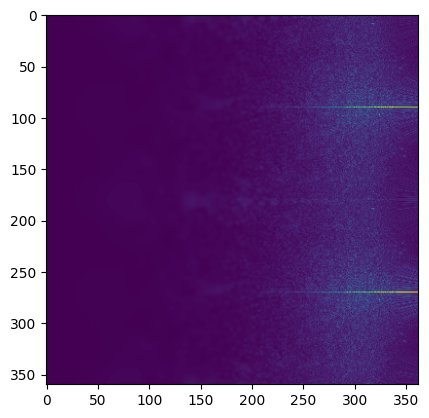

In [773]:
plt.imshow(bimageLogPolMag[6].mean(0))

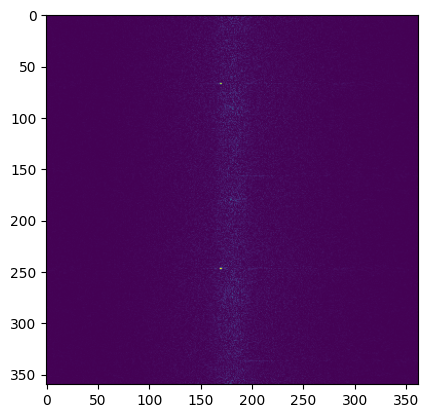

In [774]:
pc = phase_correlation(bimageLogPolMag,bimageTransfLogPolMag).sum(-3)

plt.imshow(pc.abs()[0])

In [780]:
topPc = pc.abs().flatten(-2).topk(2, dim=(-1))
predsRotsScale = torch.stack(torch.unravel_index(topPc.indices, pc.shape[-2:]), -2)
estRot = -predsRotsScale[:,0]
radius = (torch.norm(torch.tensor(bimage.shape[-2:], dtype=torch.float32))/2).long().item()
estScale = (radius ** (-((predsRotsScale[:,1] - pc.size(-1)//2)) / radius))[...,0] #A noter que le premier indice retourne des échelles à 1 qu'il faudrait filtrer

In [ ]:
def scale_loss(estScale, gtScale):
    return ((estScale/ gtScale -1)**2).sum(-1)
def rot_loss(estRot, gtAngle):
    return ((((estRot%180)[:,0]- gtAngle%180)/180*torch.pi)**2).sum(-1)

In [791]:
scale_loss(estScale,gtScale),rot_loss(estRot, gtAngle)

(tensor(0.0005), tensor(0.))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

tensor([[ 13,  13],
        [  1,  38],
        [ -1,  -1],
        [ -5,  -5],
        [-13, -13],
        [ 36,  36],
        [ 13,  13],
        [-18, -18],
        [ 24,  24],
        [ 13,  13],
        [  7,   7],
        [-12, -12],
        [  8,   9],
        [-19, -19],
        [-13, -13],
        [  4,   4],
        [-12, -12],
        [ 28,  28],
        [ -4,  -4],
        [-19, -19]])

In [670]:
gtScale.unsqueeze(-1),estScale

(tensor([[0.8082],
         [0.5355],
         [1.0166],
         [1.0810],
         [1.2456],
         [0.5542],
         [0.8034],
         [1.3469],
         [0.6744],
         [0.8087],
         [0.8853],
         [1.2111],
         [0.8713],
         [1.3724],
         [1.2312],
         [0.9349],
         [1.2164],
         [0.6322],
         [1.0635],
         [1.3643]]),
 tensor([[0.7962, 0.8093],
         [0.9680, 0.5388],
         [1.0000, 1.0164],
         [1.0673, 1.0848],
         [1.2157, 1.2356],
         [0.5476, 0.5566],
         [0.7962, 0.8093],
         [1.3187, 1.3404],
         [0.6657, 0.6766],
         [0.7962, 0.8093],
         [0.8779, 0.8923],
         [1.1961, 1.2157],
         [0.8637, 0.8637],
         [1.3404, 1.3624],
         [1.2157, 1.2356],
         [0.9218, 0.9370],
         [1.1961, 1.2157],
         [0.6238, 0.6340],
         [1.0500, 1.0673],
         [1.3404, 1.3624]]))

In [672]:
predsRotsScale[:,1]

tensor([[194, 194],
        [182, 219],
        [180, 180],
        [176, 176],
        [168, 168],
        [217, 217],
        [194, 194],
        [163, 163],
        [205, 205],
        [194, 194],
        [188, 188],
        [169, 169],
        [189, 190],
        [162, 162],
        [168, 168],
        [185, 185],
        [169, 169],
        [209, 209],
        [177, 177],
        [162, 162]])

In [640]:
logpol.thetarho_grid()

(tensor([[  0,   0,   0,  ...,   0,   0,   0],
         [  1,   1,   1,  ...,   1,   1,   1],
         [  2,   2,   2,  ...,   2,   2,   2],
         ...,
         [357, 357, 357,  ..., 357, 357, 357],
         [358, 358, 358,  ..., 358, 358, 358],
         [359, 359, 359,  ..., 359, 359, 359]]),
 tensor([[  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560],
         [  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560],
         [  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560],
         ...,
         [  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560],
         [  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560],
         [  1.0000,   1.0164,   1.0331,  ..., 344.7496, 350.4064, 356.1560]]))

In [638]:
predsRotsScale[:,1]

tensor([[194, 194],
        [182, 219],
        [180, 180],
        [176, 176],
        [168, 168],
        [217, 217],
        [194, 194],
        [163, 163],
        [205, 205],
        [194, 194],
        [188, 188],
        [169, 169],
        [189, 190],
        [162, 162],
        [168, 168],
        [185, 185],
        [169, 169],
        [209, 209],
        [177, 177],
        [162, 162]])

In [635]:
estRots%180- gtAngle.unsqueeze(-1)%180

tensor([[   0.,    0.],
        [-179.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.]])

In [620]:
gtAngle.unsqueeze(-1)%180

tensor([[ 29.],
        [179.],
        [ 73.],
        [ 22.],
        [ 18.],
        [127.],
        [ 92.],
        [ 30.],
        [ 29.],
        [  4.],
        [130.],
        [ 68.],
        [ 10.],
        [ 43.],
        [165.],
        [ 81.],
        [ 35.],
        [ 59.],
        [ 66.],
        [115.]])

tensor([[ 36.],
        [ 37.],
        [ 47.],
        [-26.],
        [  7.],
        [ 41.],
        [ 60.],
        [ -8.],
        [  0.],
        [-41.],
        [ 82.],
        [  8.],
        [-70.],
        [ 66.],
        [ 34.],
        [-83.],
        [ 53.],
        [ 67.],
        [-90.],
        [ -9.]])

In [570]:
gtAngle

tensor([ 36.,  37.,  47., -26.,   7.,  41.,  60.,  -8.,   0., -41.,  82.,   8.,
        -70.,  66.,  34., -83.,  53.,  67., -90.,  -9.])

In [311]:
gtAngle

tensor([-95., -85., -75., -65., -55., -45., -35., -25., -15.,  -5.,   5.,  15.,
         25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.])

In [263]:
255-75

180

In [221]:
gtAngle

tensor([-95., -85., -75., -65., -55., -45., -35., -25., -15.,  -5.,   5.,  15.,
         25.,  35.,  45.,  55.,  65.,  75.,  85.,  95.])

In [179]:
gtAngle

tensor([-90.0000, -80.5263, -71.0526, -61.5789, -52.1053, -42.6316, -33.1579,
        -23.6842, -14.2105,  -4.7368,   4.7368,  14.2105,  23.6842,  33.1579,
         42.6316,  52.1053,  61.5789,  71.0526,  80.5263,  90.0000])

In [174]:
gtAngle

tensor([-90.0000, -80.5263, -71.0526, -61.5789, -52.1053, -42.6316, -33.1579,
        -23.6842, -14.2105,  -4.7368,   4.7368,  14.2105,  23.6842,  33.1579,
         42.6316,  52.1053,  61.5789,  71.0526,  80.5263,  90.0000])

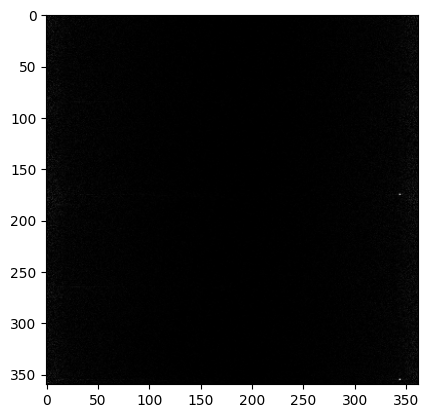

In [90]:
plt.imshow(pc.sum(-3).abs()[0], cmap='gray')